# Statistics on Decision Tree

We will arange data and train Desicion trees on the data.
The we will try to train again only using quarters from the same cluster (using the quarter classifier).

Our randomly chosen 5 stocks are: 
'SHW', 'MNK', 'BIO', 'KYTH', 'KRO'

# Basic Tree

In [1]:
from Utilities.orginizers import LearningData, TrainingData
from sklearn.model_selection import KFold, cross_val_score
from itertools import product

from multiprocessing import Pool
import matplotlib.pyplot as plt
import Utilities
import numpy as np
import warnings
import logging
import pandas

%matplotlib inline

ld = LearningData()

In [3]:
stock_names = ('SHW', 'MNK', 'BIO', 'KYTH', 'KRO')
logging.getLogger().setLevel(logging.ERROR)
stocks = [TrainingData(sn, ld=ld).add_history(10).set_threshold(0.8).get() for sn in stock_names]

In [4]:
import os
print("Samples per stock:")
print(os.linesep.join(['{} {}'.format(sn, len(data)) for sn, (data, classes) in zip(stock_names, stocks)]))
print("percent of positive classification per stock")
print(os.linesep.join(['{} {}'.format(sn, float(classes.sum())/len(classes)) for sn, (data, classes) in zip(stock_names, stocks)]))
print(stocks[0][0].describe())

Samples per stock:
SHW 7856
MNK 819
BIO 2343
KYTH 718
KRO 3220
percent of positive classification per stock
SHW 0.20035641547861507
MNK 0.1978021978021978
BIO 0.15151515151515152
KYTH 0.201949860724234
KRO 0.20031055900621117
             change         close   ex-divident          high           low  \
count  7.856000e+03  7.856000e+03  7.856000e+03  7.856000e+03  7.856000e+03   
mean   9.406370e-17  1.157707e-16  2.894268e-17  8.682803e-17 -5.788536e-17   
std    1.000064e+00  1.000064e+00  1.000064e+00  1.000064e+00  1.000064e+00   
min   -9.826683e-01 -7.119542e-01 -8.284943e-02 -7.085131e-01 -7.121943e-01   
25%   -6.546044e-01 -5.457205e-01 -8.284943e-02 -5.460775e-01 -5.453433e-01   
50%   -2.623459e-01 -4.379958e-01 -8.284943e-02 -4.402343e-01 -4.366578e-01   
75%    3.424440e-01 -5.367340e-02 -8.284943e-02 -5.257307e-02 -5.558393e-02   
max    1.405070e+01  3.669299e+00  2.486703e+01  3.637956e+00  3.656663e+00   

               open   split_ratio       volume  change1_days_b

In [5]:
def run_model(model, inp=stocks):
    scores = {sn: [] for sn in stock_names}
    for sn, (data, classes) in zip(stock_names, inp):
        scores[sn] = (sum(cross_val_score(model, data, classes))/3) 
    return scores

def get_best_model(models, accs):
    best_model = (0 , models[0])
    for model, accs in zip(models, accs):
        if sum(accs.values()) > best_model[0]:
            best_model = (sum(accs.values()), model)
    return best_model

def median(lst):
    quotient, remainder = divmod(len(lst), 2)
    if remainder:
        return sorted(lst)[quotient]
    return sum(sorted(lst)[quotient - 1:quotient + 1]) / 2.

def get_best_median_model(models, accs):
    best_model = (0 , models[0])
    for model, accs in zip(models, accs):
        if median(accs.values()) > best_model[0]:
            best_model = (median(accs.values()), model)
    return best_model

In [6]:
from sklearn.tree import DecisionTreeClassifier
from pandas import DataFrame
cuts=[]

for i in range(1, 51):
    tmodel = DecisionTreeClassifier(min_samples_leaf=0.05, max_depth=30)
    tree_stocks = [(pandas.get_dummies(data.apply(lambda s: pandas.qcut(s.rank(method='first'), i))), classes) for data, classes in stocks]
    temp_accs = [run_model(tmodel, tree_stocks)]
    data = []
    taccs = temp_accs[0]
    for tsn, tacc in taccs.items():
        data.append((tmodel.criterion, tmodel.max_depth, tmodel.min_samples_leaf, tsn, tacc))
    temp_results = DataFrame(data, columns=('criterion', 'max_depth', 'min_samples', 'stock', 'accuracy'))
    cuts.append((temp_results['accuracy'].median(), i))
        

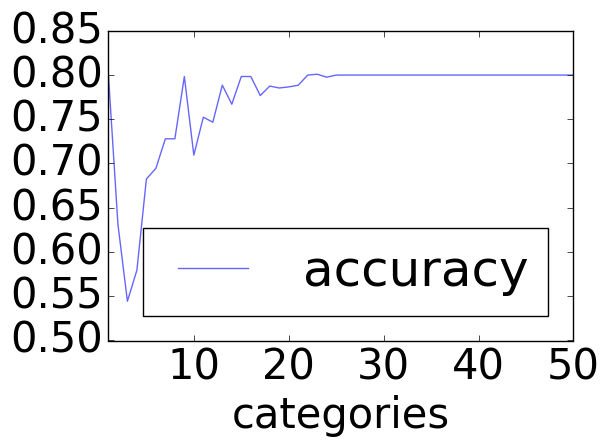

In [10]:
from pandas import DataFrame
res = DataFrame(cuts, columns=['accuracy', 'categories'])
import numpy as np

res = res.set_index('categories')
res.plot(kind='line', label='accuracy', alpha=alpha)
plt.legend(loc='best')

In [23]:
res.loc[res['accuracy'].apply(lambda r: r == res.accuracy.max())]

,accuracy
categories,
23,0.800621


In [24]:
best_cut=23

In [31]:
from sklearn.tree import DecisionTreeClassifier

# create iterables for all options and use itertools product
criterion=['gini', 'entropy']
max_depth=[5, 10, 50]
# using percentages
min_samples_leaf=[0.005, 0.01, 0.02, 0.05, 0.1]

tree_stocks = [(pandas.get_dummies(data.apply(lambda s: pandas.qcut(s.rank(method='first'), best_cut))), classes) for data, classes in stocks]

tmodels = [DecisionTreeClassifier(criterion=c, max_depth=md, min_samples_leaf=msl) 
          for c, md, msl in product(criterion, max_depth, min_samples_leaf)]

In [32]:
def run_model_t(model):
    return run_model(model, tree_stocks)
taccuracies = list(map(run_model_t, tmodels))

In [ ]:
import pickle
taccuracies = pickle.load(open('DecisionTree.p', 'rb'))

In [35]:
from pandas import DataFrame

# data should be list of lists and each row should be:
# criterion, max_depth, min_samples, stock, accuracy
data = []
for tmodel, taccs in zip(tmodels, taccuracies):
    for tsn, tacc in taccs.items():
        data.append((tmodel.criterion, tmodel.max_depth, tmodel.min_samples_leaf, tsn, tacc))
tresults = DataFrame(data, columns=('criterion', 'max_depth', 'min_samples', 'stock', 'accuracy'))

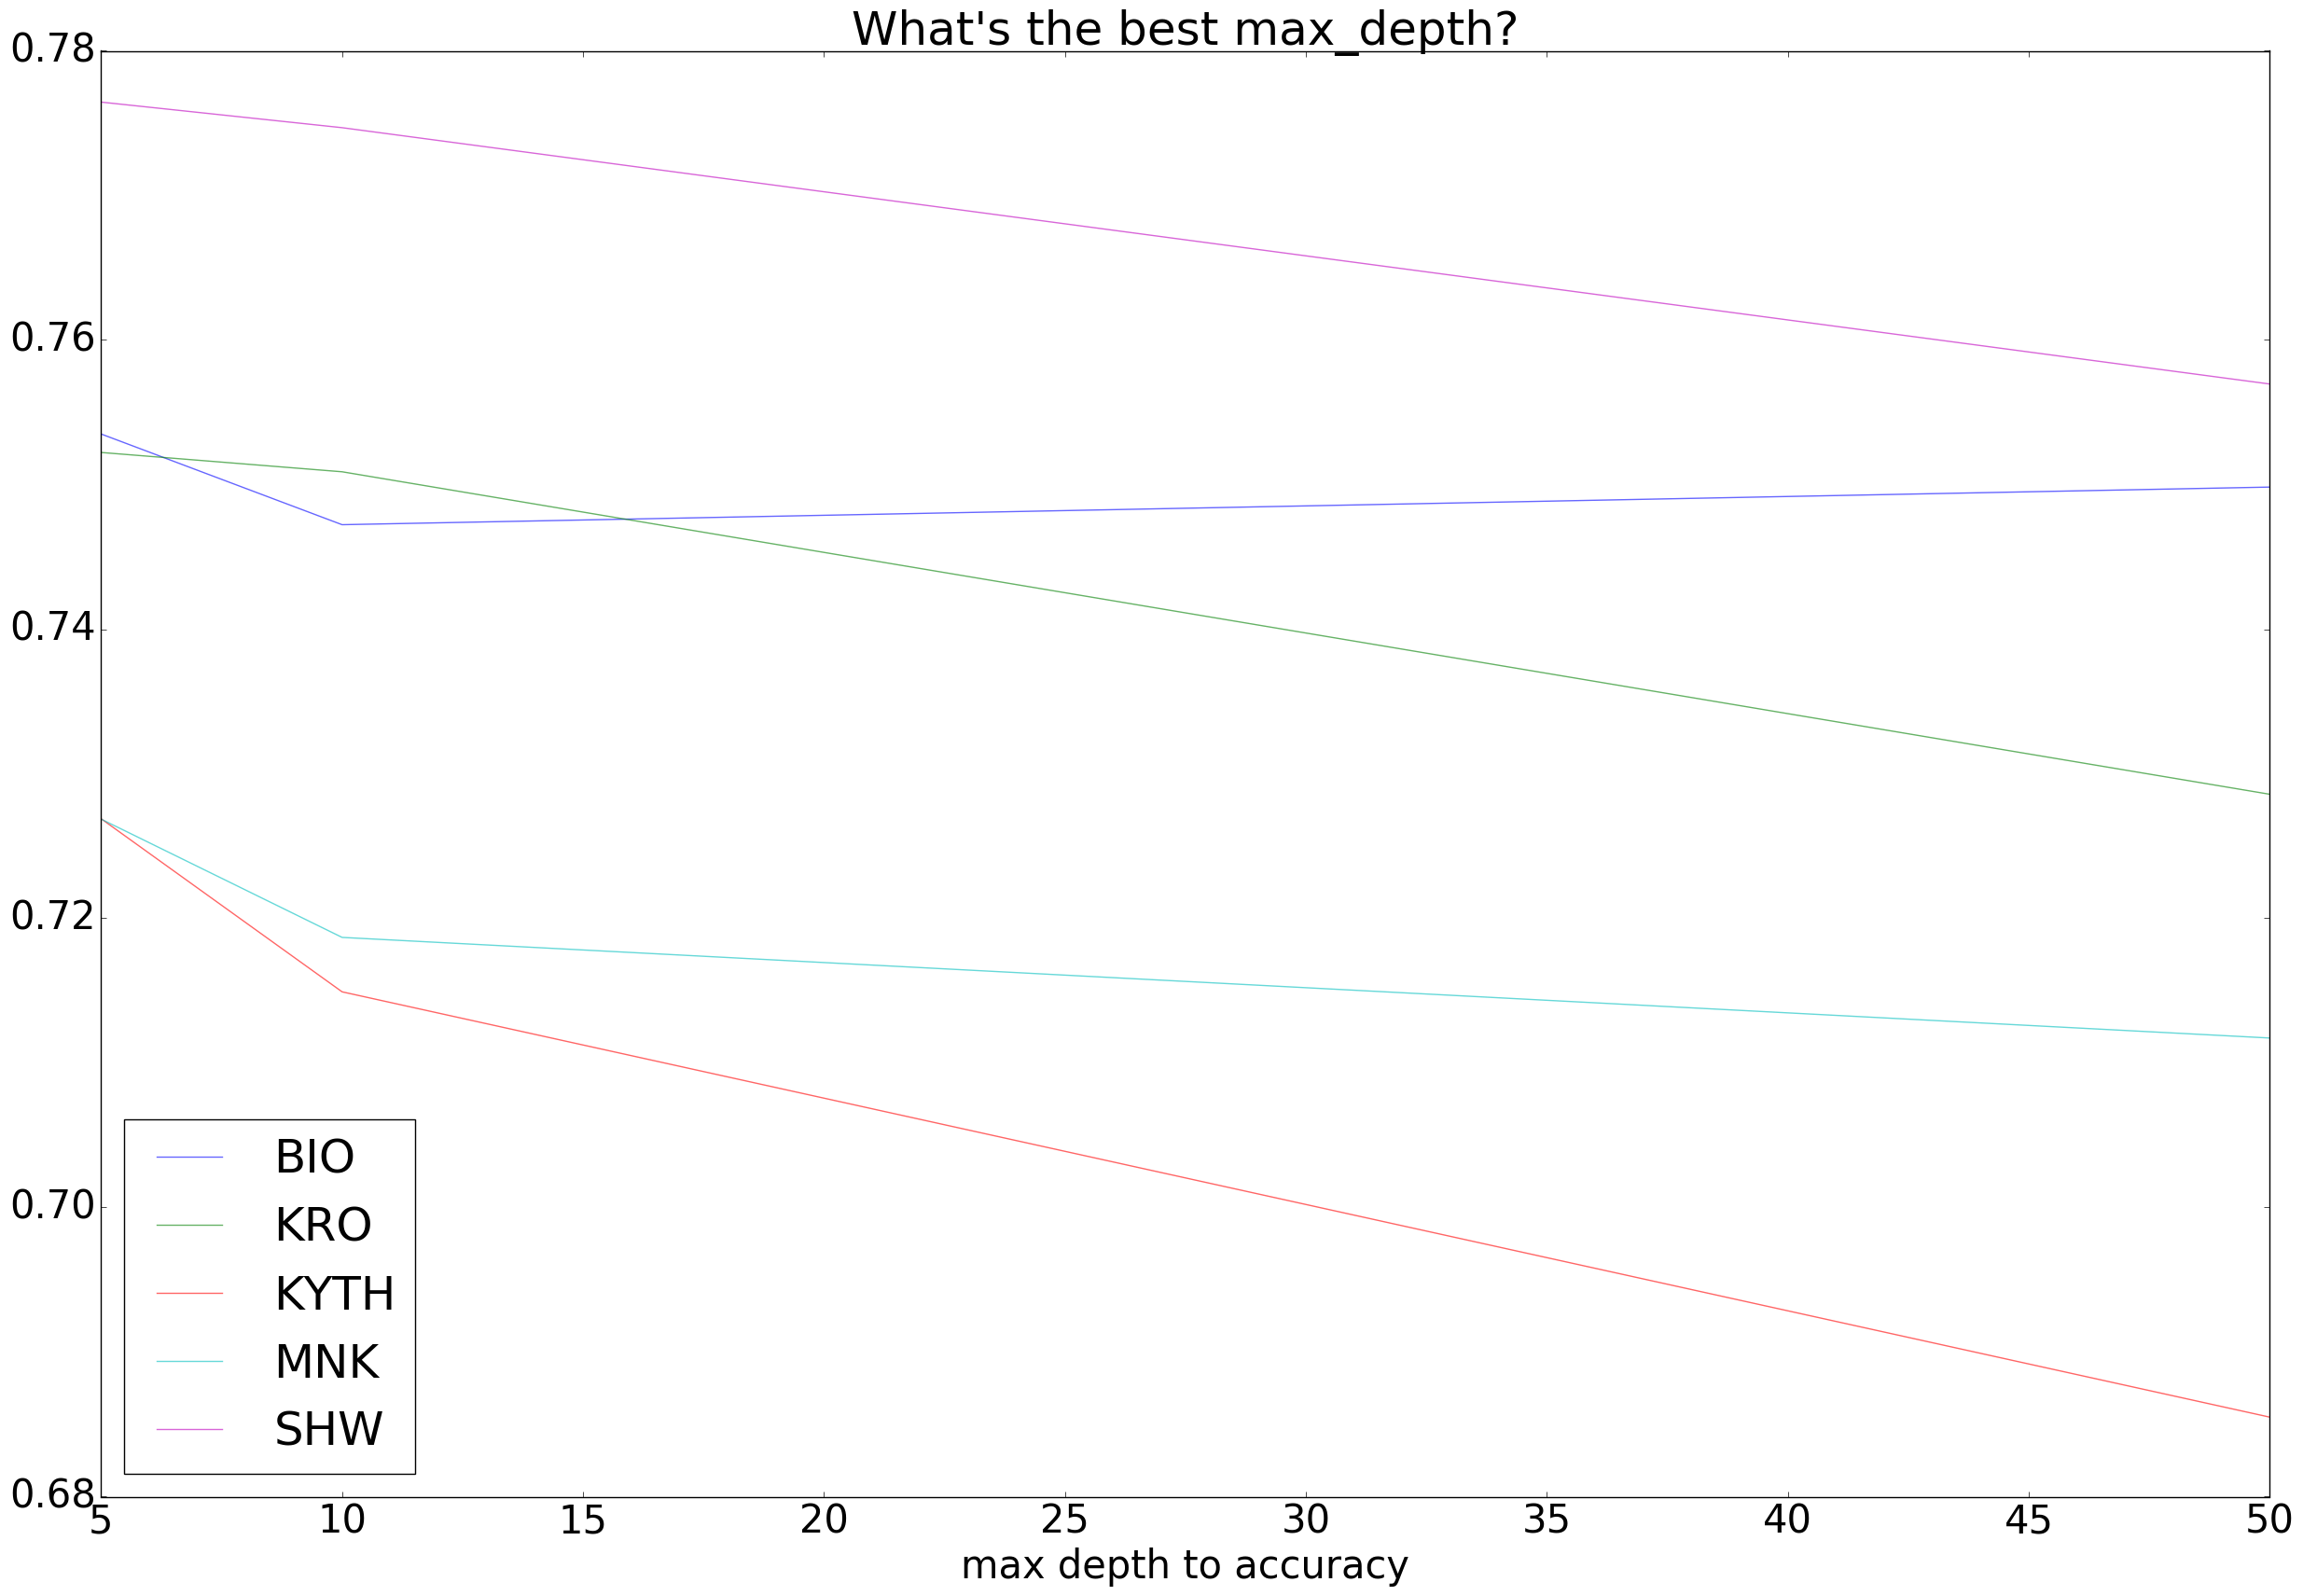

In [36]:
import numpy as np

%matplotlib inline

plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in tresults.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 12).groupby('max_depth').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('max depth to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best max_depth?" )

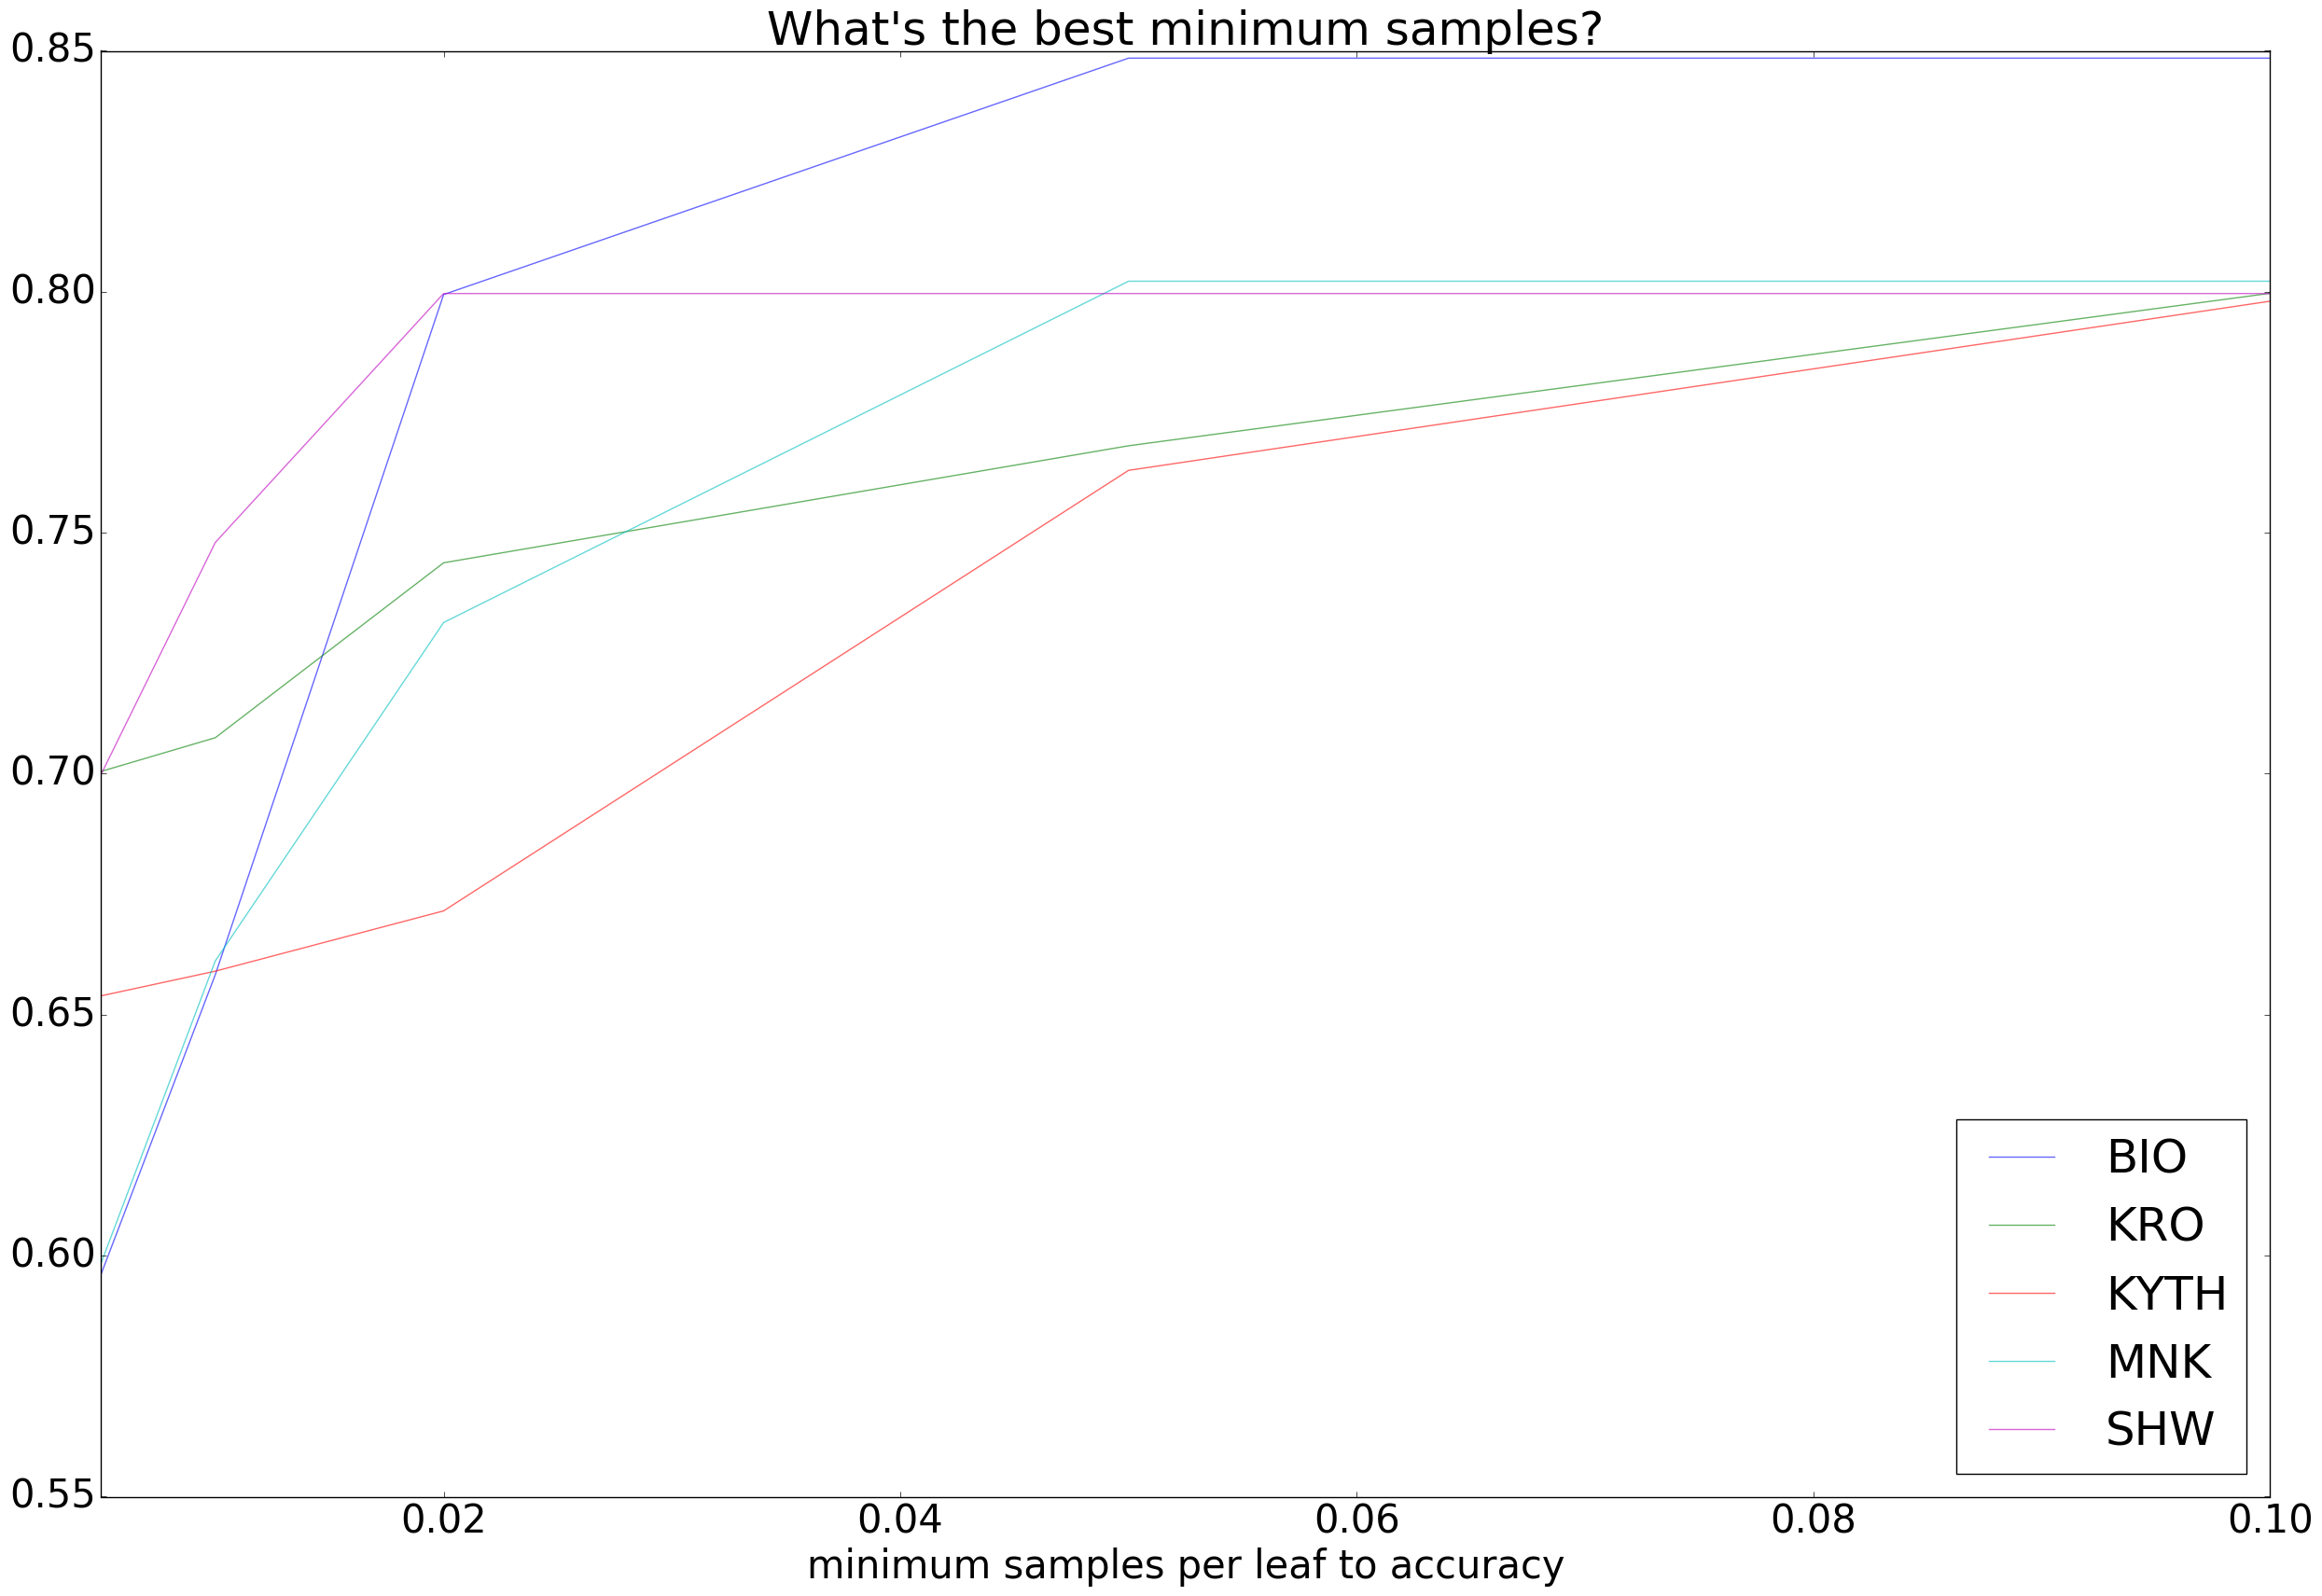

In [37]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in tresults.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 1).groupby('min_samples').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('minimum samples per leaf to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best minimum samples?" )

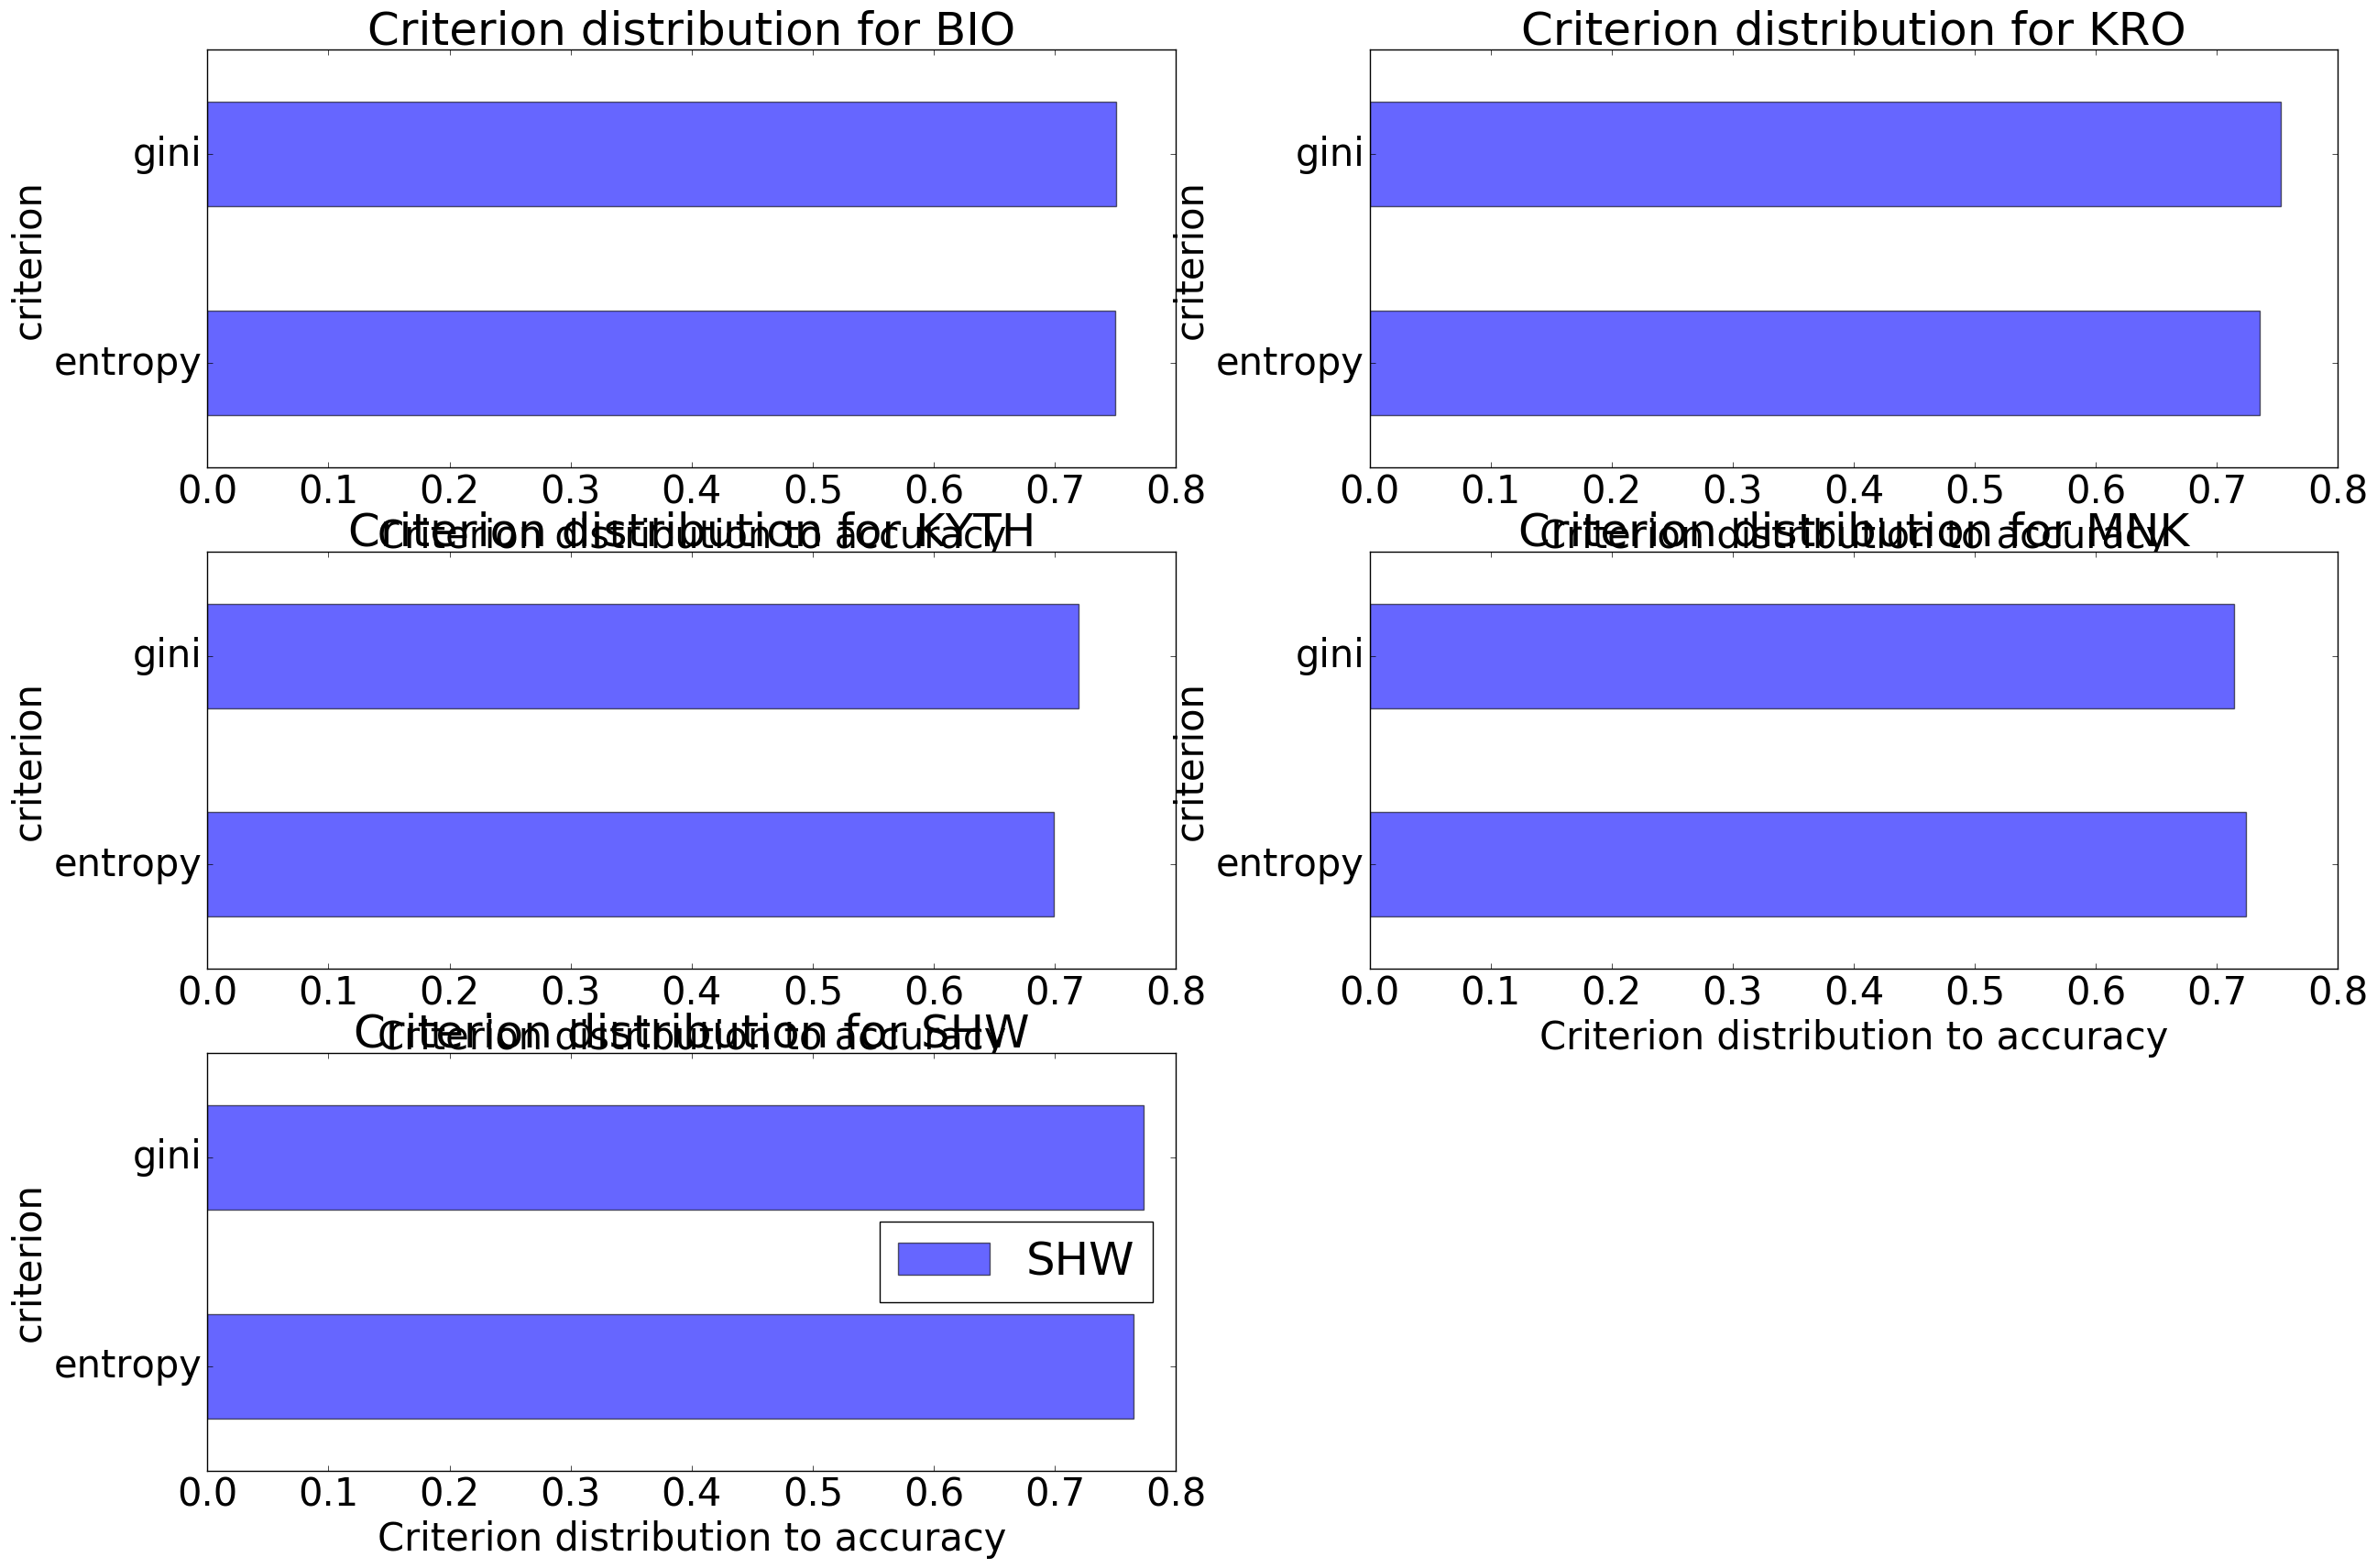

In [38]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

locations = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]

for i, (name, group) in enumerate(tresults.groupby('stock')):
    ax1 = plt.subplot2grid((3,2), locations[i])
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 1).groupby('criterion').agg('mean')['accuracy'].plot(kind='barh', label=name, alpha=alpha)
    ax1.set_xlabel('Criterion distribution to accuracy')
    ax1.set_title("Criterion distribution for {}".format(name))
plt.legend(loc='best')


The best average accuracy model is:

In [39]:
print(get_best_model(tmodels, taccuracies))
print(get_best_median_model(tmodels, taccuracies))

(4.0490012416418191, DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=0.05,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))
(0.80062136881632162, DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=0.05,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))


Which is like just saying always false but we can work with it because we use adaboost later on. An important note is that we don't want to increase the amount of samples per leaf or decrease max depth as the classifier will be meaningless. Even we prefer to look at less samples per leaf so we will have more then 20 leaves:

In [40]:
t2combined = [(model, accs) for model, accs in zip(tmodels, taccuracies) if model.min_samples_leaf < 0.05]
t2models = [top[0] for top in t2combined]
t2accuracies = [top[1] for top in t2combined]

print(get_best_model(t2models, t2accuracies))
print(get_best_median_model(t2models, t2accuracies))

(3.756676017364069, DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=0.02,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))
(0.74377141541464409, DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=0.02,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))


# Variance Reduction
We will try 3 approches. 

    1. using standard sklearn feature selection. 
    2. using QuarterClusterer try using data with less variance.
    3. using relation strength classifier.

## Standard feature selection

We have plenty of samples so it seems wiser to use mutual_info score func, and trying to remove features by those who have small variance.

In [41]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

results = []
for i in range(1, 121, 10):
    filtered_tree_stocks = [(SelectKBest(score_func=mutual_info_classif, k=i).fit_transform(data, classes), classes) for data, classes in tree_stocks]
    results.append((i, sum(run_model(DecisionTreeClassifier(), filtered_tree_stocks).values())))
    
results.sort(key=lambda t: t[1])
for t in results[:10]:
    print('{} {}'.format(t[0],t[1]))


111 3.156453087346391
81 3.327075192728057
91 3.3879586284734025
101 3.39110649576555
51 3.414492139281367
71 3.421769736457957
61 3.572264848060709
41 3.649800143423675
31 3.7594118580196656
11 3.9042078953200865


In [42]:
from sklearn.feature_selection import VarianceThreshold

results2 = []
for i in range(1, 11):
    try:
        filtered_tree_stocks = [(VarianceThreshold(threshold=float(i)/100).fit_transform(data, classes), classes) for data, classes in tree_stocks]
        results2.append((i, sum(run_model(DecisionTreeClassifier(), filtered_tree_stocks).values())))
    except Exception as e:
        print('Skipping threshold {} as it doesnt have enough variance: {}'.format(float(i)/100, str(e)))
    
results2.sort(key=lambda t: t[1])
for t in results2:
    print('{} {}'.format(t[0],t[1]))

Skipping threshold 0.05 as it doesnt have enough variance: No feature in X meets the variance threshold 0.05000
Skipping threshold 0.06 as it doesnt have enough variance: No feature in X meets the variance threshold 0.06000
Skipping threshold 0.07 as it doesnt have enough variance: No feature in X meets the variance threshold 0.07000
Skipping threshold 0.08 as it doesnt have enough variance: No feature in X meets the variance threshold 0.08000
Skipping threshold 0.09 as it doesnt have enough variance: No feature in X meets the variance threshold 0.09000
Skipping threshold 0.1 as it doesnt have enough variance: No feature in X meets the variance threshold 0.10000
2 2.726942309418809
4 2.7374675053385014
1 2.768616238299966
3 2.7767385632159662


# Using the Quarter Classifier

The idea is that some quarters behave the same and so we can really decrease our data's variance if we cluster them together and then try to predict with the narowred down data.

In [43]:
from Classifiers import classifiers

quarterizer = classifiers.Quarterizer().fit(stocks[0][0])
quarters = pandas.concat([quarterizer.transform(d) for d,c in stocks])
quarters.describe()

,0,1,2,3,4,5,6,7,8,9,...,712,713,714,715,716,717,718,719,720,721
count,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,...,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000
mean,-1.166515,-1.160028,-1.153850,-1.148183,-1.143229,-1.139189,-1.136266,-1.134661,-1.134576,-1.136045,...,-0.567933,-0.445574,-0.327797,-0.220037,-0.127017,-0.053462,-0.003060,0.024629,0.031082,0.017774
std,2.697344,2.695870,2.716602,2.741835,2.762661,2.775970,2.781992,2.782545,2.779904,2.776307,...,5.862200,6.001641,6.110431,6.228944,6.367522,6.496243,6.565312,6.536801,6.374755,6.042730
min,-7.180453,-7.081043,-7.237665,-7.883670,-8.237539,-8.337366,-8.221242,-7.927261,-7.493517,-6.958100,...,-9.693521,-10.968565,-11.948655,-12.537482,-12.638734,-12.156099,-10.993268,-9.053928,-7.736395,-7.671360
25%,-2.843656,-2.843992,-2.843055,-2.845738,-2.848458,-2.850582,-2.862501,-2.848320,-2.840663,-2.848786,...,-2.970533,-2.955282,-2.956861,-2.901402,-2.911704,-2.887583,-2.875127,-2.870263,-2.870554,-2.831041
50%,-2.584973,-2.600785,-2.614316,-2.584422,-2.599009,-2.597153,-2.593953,-2.591194,-2.599746,-2.604249,...,-2.215353,-2.221403,-2.063798,-2.052390,-2.011536,-2.112609,-2.189342,-2.065904,-2.038702,-1.972767
75%,1.946519,2.002208,1.961620,1.913106,1.929182,1.987506,2.048697,2.045505,2.088920,2.119520,...,0.739899,0.742141,1.090213,1.352441,1.172843,1.389354,1.539184,1.424363,1.433567,1.233152
max,4.602059,4.935822,5.230256,5.508054,5.794210,6.021569,6.191266,6.304439,6.362222,6.368024,...,69.139259,68.043155,64.494012,58.977252,51.978296,48.640885,52.352624,54.136662,53.559761,50.188682


In [44]:
from sklearn.cluster import KMeans

clusters = 6
q_clf = KMeans(n_clusters=clusters).fit(quarters.drop(['start', 'end'], axis=1))

In [45]:
q_data = [quarterizer.transform(d) for d, c in stocks]
c_stocks = [(d, q_clf.predict(d.drop(['start', 'end'], axis=1))) for d in q_data]

combined = []
for d, c in stocks:
    d2 = d.copy(False)
    d2['class'] = c
    combined.append(d2)
by_classes = [quarterizer.cut_by_classes(d, qs,  qcs) for d, (qs, qcs) in zip(combined, c_stocks)]

In [53]:
def run_clustered_model(model, class_dict=by_classes):
    scores = {}
    for sn, d_dict in zip(stock_names, class_dict):
        scores[sn] = 0
        for c in d_dict.keys():
            data, classes = d_dict[c].drop('class', axis=1), d_dict[c]['class']
            if classes.isnull().sum() > 0:
                print("filling na: {}".format(classes.isnull().sum()))
                classes = classes.fillna(classes.median())
            if len(classes.unique()) == 1:
                scores[sn] += 0.8
            else:
                classes = list(classes)
                try:
                    scores[sn] += sum(cross_val_score(model, data, classes))/3
                except Exception as e:
                    print(sn, c)
                    print(classes)
                    print(str(e))
        scores[sn] /= len(d_dict)
    return scores

In [54]:
s_cluster_accuracies = run_clustered_model(DecisionTreeClassifier())

filling na: 1


In [56]:
print(s_cluster_accuracies)

{'SHW': 0.9996690288756459, 'KRO': 0.95634066318620869, 'KYTH': 0.99384920634920637, 'BIO': 0.9949425581502489, 'MNK': 0.9917046076813324}


In [55]:
print(get_best_model([DecisionTreeClassifier()], [s_cluster_accuracies]))
print(get_best_median_model([DecisionTreeClassifier()], [s_cluster_accuracies]))

(4.9365060642426419, DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))
(0.99384920634920637, DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))
